In [2]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations
from joblib import Parallel, delayed
from copy import copy

In [3]:
sns.set_style('white')

In [4]:
events = ['PA', '1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP', 'SB']

In [5]:
df = pd.concat({n: pd.read_csv(f'results/{n}/offense.csv') for n in [2024, 2025]})

# Weight 2024 down, so it counts less.
# Lifting relative weighting used in ZiPS, which is probably decent here
for n in events:
    df.loc[2024, n] = (df.loc[2024, n] * 5/8).values

sum_df = df.groupby('Name')[['PA', '1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP', 'SB']].sum()
rate_df = sum_df.divide(sum_df.PA, axis=0)

In [6]:
sums_df = sum_df.sum()
bh_rates = sums_df.loc['1B': '3B'] / sums_df.loc['1B': '3B'].sum()

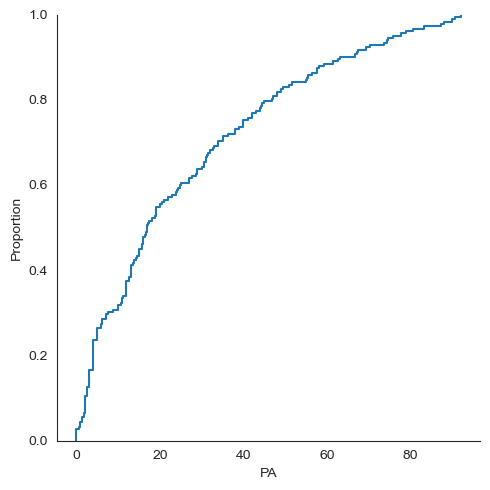

In [7]:
# Plot total weighted PA to get sense of reasonable cutoff
sns.displot(sum_df.PA, stat='proportion', kind='ecdf')

In [8]:
min_pa = 30
filtered_rate_df = rate_df.loc[sum_df['PA'] > min_pa]
sums_df = sum_df.loc[sum_df['PA'] > min_pa].sum()

In [9]:
# We initialize this now.
# These are going to be determined by playing around with the graphs below
# Our goal is to set initial hyperparameters where the beta distribution
# roughly matches the empirical distribution of rates

init_hyperparams = {}

In [10]:
def get_dist_plots(event, a):
    global filtered_rate_df
    global init_hyperparams


    fig, ax1 = plt.subplots()
    sns.histplot(filtered_rate_df[event], ax=ax1)

    x_low, x_hi = ax1.get_xbound()
    b = a / (sums_df[event] / sums_df['PA'])
    x = np.linspace(max(0,x_low), x_hi, 1000)
    print(a, b)

    init_hyperparams[event] = (float(a), b)


    ax2 = ax1.twinx()
    ax2.plot(x, beta.pdf(x, a, b), color='k', lw=3, scaley=True)
    ax2.set_ylim(0)
    return ax1

4 19.282868525896415


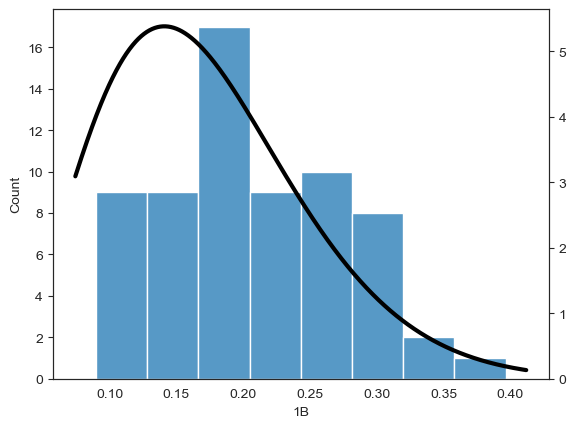

In [11]:
ax1 = get_dist_plots('1B', 4)

1.5 34.049755301794455


<Axes: xlabel='2B', ylabel='Count'>

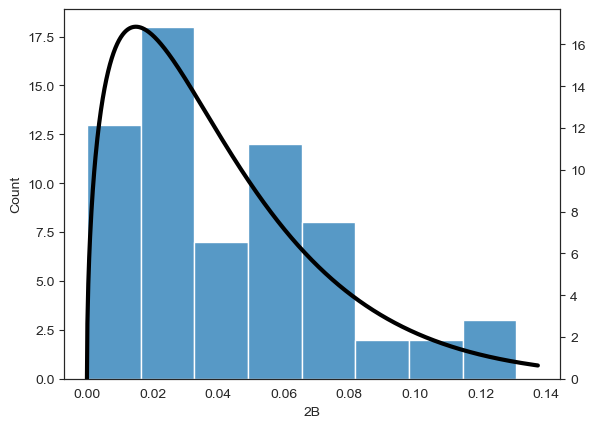

In [12]:
get_dist_plots('2B', 1.5)

0.5 132.52380952380952


<Axes: xlabel='3B', ylabel='Count'>

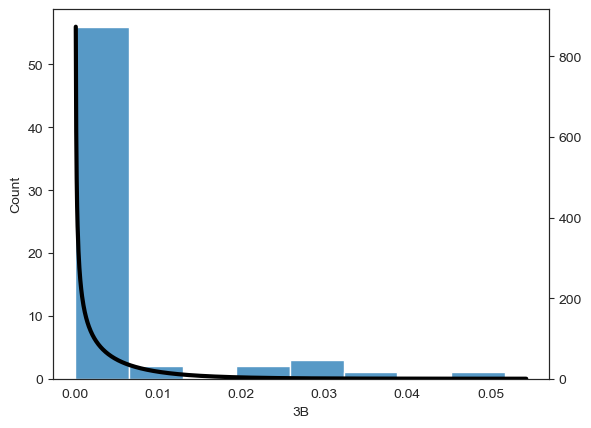

In [13]:
get_dist_plots('3B', 0.5)

0.5 38.333333333333336


<Axes: xlabel='HR', ylabel='Count'>

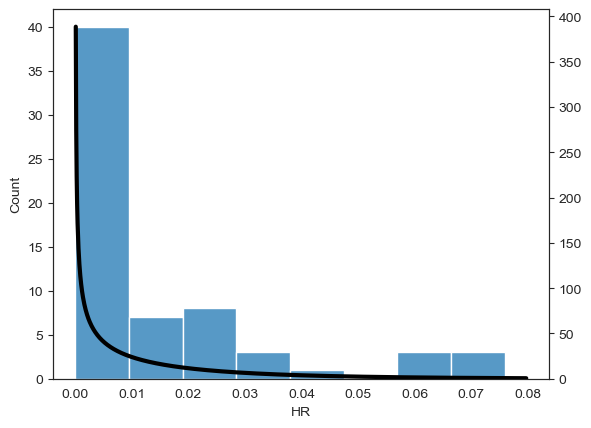

In [14]:
get_dist_plots('HR', 0.5)

3 29.9247311827957


<Axes: xlabel='BB', ylabel='Count'>

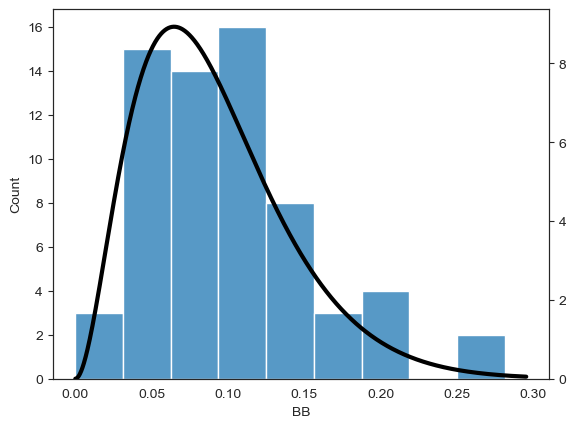

In [15]:
get_dist_plots('BB', 3)

1.5 52.77496839443742


<Axes: xlabel='HBP', ylabel='Count'>

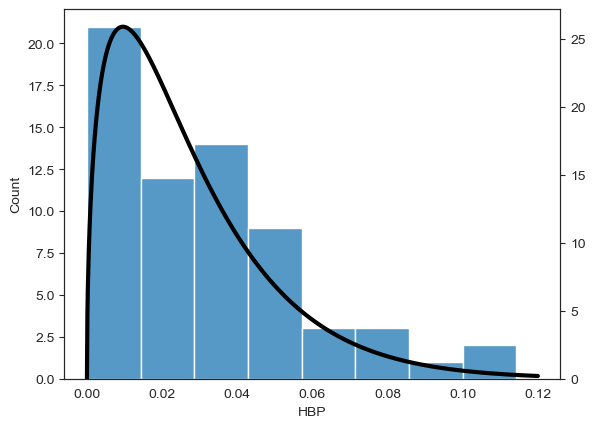

In [16]:
get_dist_plots('HBP', 1.5)

2 10.246686303387335


<Axes: xlabel='K', ylabel='Count'>

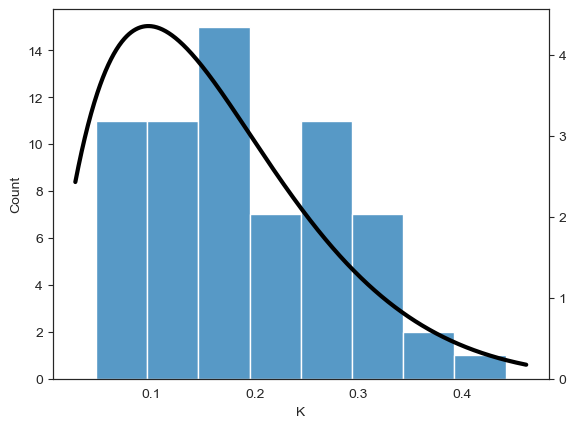

In [17]:
get_dist_plots('K', 2)

1 15.166212534059945


<Axes: xlabel='SB', ylabel='Count'>

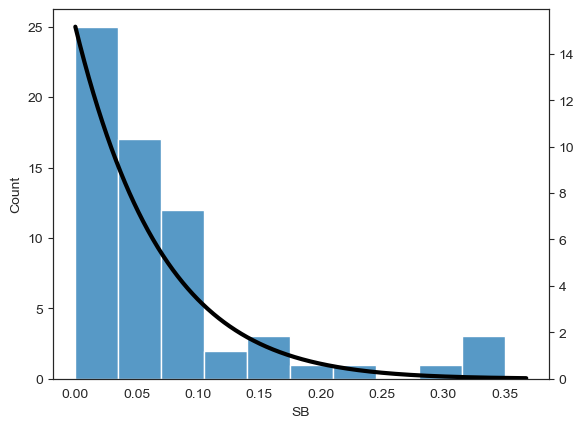

In [18]:
get_dist_plots('SB', 1)

In [19]:
init_hyperparams

{'1B': (4.0, np.float64(19.282868525896415)),
 '2B': (1.5, np.float64(34.049755301794455)),
 '3B': (0.5, np.float64(132.52380952380952)),
 'HR': (0.5, np.float64(38.333333333333336)),
 'BB': (3.0, np.float64(29.9247311827957)),
 'HBP': (1.5, np.float64(52.77496839443742)),
 'K': (2.0, np.float64(10.246686303387335)),
 'SB': (1.0, np.float64(15.166212534059945))}

In [20]:
# Only care about our team
l_df = df.set_index('Team', append=True).loc[(2025, slice(None), 'Legends')]

# Filtered on playoff_eligible pool
playoff_eligible = l_df.loc[l_df.GP >= 7, 'Name'].values

# get sums for playoff eligible players
lu_df = sum_df.loc[playoff_eligible]

playoff_eligible

array(['Cody Stevens', 'Kasim Hussain', 'Kellen Hatheway',
       'Steven Ferguson', 'Rico Pena', 'Derek Chance', 'Adam Tuszynski',
       'Matthew Polites', 'Andrew Gerety', 'Ryan Stevens',
       'Alexander Delk', 'Brian Holman', 'Jake Sahagian', 'Kyle Henke',
       'Christian LeClaire', 'Brett Klasko', 'Kyle Aube'], dtype=object)

In [21]:
lu_df

,PA,1B,2B,3B,HR,BB,K,HBP,SB
Name,,,,,,,,,
Cody Stevens,80.625,23.375,8.875,3.000,1.625,7.500,5.750,3.250,3.250
Kasim Hussain,61.375,9.625,4.875,0.000,2.000,11.500,16.250,2.000,2.000
Kellen Hatheway,66.750,16.625,3.500,1.875,3.875,4.250,17.375,2.250,5.250
Steven Ferguson,67.500,11.125,1.625,0.625,1.625,7.250,23.375,3.625,5.000
Rico Pena,32.000,6.000,1.000,0.000,0.000,9.000,8.000,1.000,1.000
Derek Chance,74.625,13.875,5.500,0.000,1.000,6.250,4.375,1.625,6.875
Adam Tuszynski,43.000,11.000,1.000,0.000,0.000,3.000,3.000,4.000,3.000
Matthew Polites,31.375,5.625,1.875,0.000,1.000,3.625,6.250,2.250,1.875
Andrew Gerety,56.500,11.625,7.125,0.000,0.000,4.500,7.125,0.000,8.500


In [22]:
init_hyperparams

{'1B': (4.0, np.float64(19.282868525896415)),
 '2B': (1.5, np.float64(34.049755301794455)),
 '3B': (0.5, np.float64(132.52380952380952)),
 'HR': (0.5, np.float64(38.333333333333336)),
 'BB': (3.0, np.float64(29.9247311827957)),
 'HBP': (1.5, np.float64(52.77496839443742)),
 'K': (2.0, np.float64(10.246686303387335)),
 'SB': (1.0, np.float64(15.166212534059945))}

In [23]:
class Player:
    def __init__(self, player_name):
        self.player_name = player_name
        self.hyperparams = copy(init_hyperparams)
        self.weights = {}

    def ab(self):
        return np.random.choice(list(self.weights.keys()), p=list(self.weights.values()))

    def update_hyperparams(self, results):
        pa = results.loc['PA']
        weights = {}
        for i in ['1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP']:
            a, b = self.hyperparams[i]
            a += results.loc[i]
            b += (pa - a)
            self.hyperparams[i] = a, b
            self.weights[i] = beta.mean(a, b)

        nonk = 1 - np.sum(list(self.weights.values()))
        self.weights['OUT'] = nonk * .9
        self.weights['ERR'] = nonk * .1

        a, b = self.hyperparams['SB']
        a += results.loc['SB']
        b += (pa - a)
        self.hyperparams['SB'] = a, b
        self.weights['SB'] = beta.mean(a, b)

In [24]:
weights_df = lu_df.copy()
weights_df['OUT'] = np.nan
weights_df['ERR'] = np.nan
for n in playoff_eligible:
    player = Player(n)
    player.update_hyperparams(lu_df.loc[n])
    weights_df.loc[n] = pd.Series(player.weights, name=n)
weights_df.drop(columns=['PA'], inplace=True)
weights_df

,1B,2B,3B,HR,BB,K,HBP,SB,OUT,ERR
Name,,,,,,,,,,
Cody Stevens,0.274002,0.090473,0.016420,0.017863,0.094980,0.085285,0.035607,0.044367,0.346831,0.038537
Kasim Hussain,0.168923,0.066807,0.002579,0.025073,0.158818,0.254811,0.030661,0.039195,0.263095,0.029233
Kellen Hatheway,0.239734,0.049603,0.011918,0.041634,0.074994,0.251634,0.031374,0.076297,0.269198,0.029911
Steven Ferguson,0.174286,0.030773,0.005624,0.020079,0.105209,0.326380,0.042611,0.072581,0.265534,0.029504
Rico Pena,0.194997,0.037850,0.003039,0.007109,0.193784,0.236705,0.029490,0.042403,0.267324,0.029703
Derek Chance,0.190346,0.064412,0.002414,0.013279,0.088475,0.075113,0.024529,0.087703,0.487288,0.054143
Adam Tuszynski,0.240837,0.032447,0.002849,0.006148,0.082277,0.093903,0.057426,0.068768,0.435704,0.048412
Matthew Polites,0.190000,0.051586,0.003051,0.021518,0.108076,0.198214,0.044563,0.061773,0.344693,0.038299
Andrew Gerety,0.206181,0.095251,0.002645,0.005272,0.086781,0.136711,0.013727,0.132559,0.408088,0.045343


In [25]:
lw_df = pd.read_csv('data/guts/linear_weights.csv', index_col='outcome')
lw_df

,run_exp_change
outcome,
1B,0.973550
2B,1.320377
3B,1.433249
BB,0.866691
HBP,0.871860
HR,1.838045
wOBA_scale,0.871340
runSB,0.200000


In [26]:
bayes_woba = (weights_df['1B'] * lw_df.loc['1B', 'run_exp_change']
              + weights_df['2B'] * lw_df.loc['2B', 'run_exp_change']
              + weights_df['3B'] * lw_df.loc['3B', 'run_exp_change']
              + weights_df['HR'] * lw_df.loc['HR', 'run_exp_change']
              + weights_df['BB'] * lw_df.loc['BB', 'run_exp_change']
              + weights_df['HBP'] * lw_df.loc['HBP', 'run_exp_change']
              + weights_df['ERR'] * lw_df.loc['1B', 'run_exp_change']
              + weights_df['SB'] * lw_df.loc['runSB', 'run_exp_change']
              ).sort_values(ascending=False)

bayes_obp = (1 - weights_df['OUT'] - weights_df['K'])

bayes_df = pd.concat([bayes_woba, bayes_obp], axis=1, keys=['wOBA (Bayes)', 'OBP (Bayes)'])
bayes_df['SLG bias (Bayes)'] = bayes_df['wOBA (Bayes)'] / bayes_df['OBP (Bayes)'] - 1

<Axes: title={'center': 'Bayesian Offense Statistics'}, ylabel='Name'>

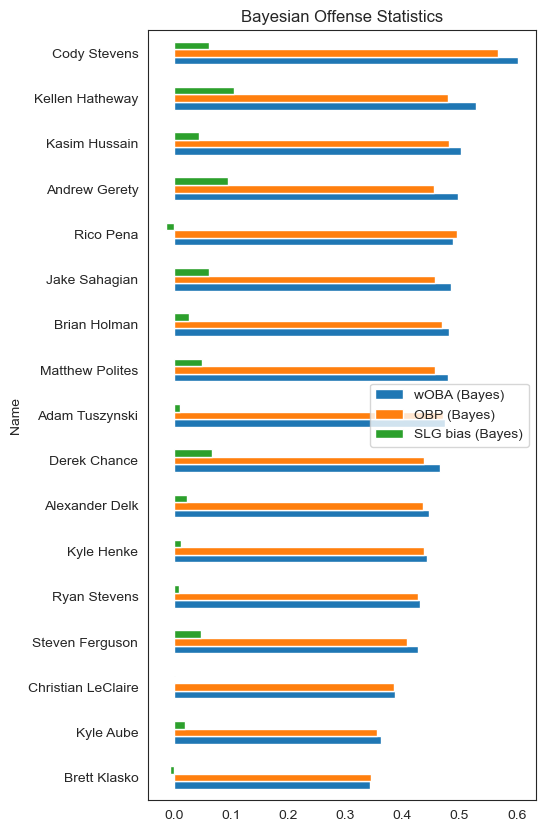

In [27]:
bayes_df.sort_values('wOBA (Bayes)').plot.barh(figsize=(5,10), title='Bayesian Offense Statistics')

In [28]:
bayes_df.sort_values('wOBA (Bayes)', ascending=False).round(3)

,wOBA (Bayes),OBP (Bayes),SLG bias (Bayes)
Name,,,
Cody Stevens,0.602,0.568,0.061
Kellen Hatheway,0.529,0.479,0.104
Kasim Hussain,0.503,0.482,0.044
Andrew Gerety,0.498,0.455,0.094
Rico Pena,0.488,0.496,-0.015
Jake Sahagian,0.485,0.457,0.061
Brian Holman,0.481,0.469,0.026
Matthew Polites,0.479,0.457,0.048
Adam Tuszynski,0.475,0.470,0.010


In [79]:
class Lineup:
    def __init__(self, order: tuple, weights: pd.DataFrame):
        self.order = order
        self.length = len(order)
        self.index = 0
        self.weights = weights

    def __iter__(self):
        return self

    def __next__(self):
        if self.index == self.length:
            self.index = 0
        player = self.order[self.index]
        self.index += 1
        return np.random.choice(self.weights.columns, p=self.weights.loc[player])


class Game:
    def __init__(self, order: tuple, weights: pd.DataFrame):
        self.lineup = Lineup(order, weights)
        self.order = order
        self.weights = weights
        self.inning = 1
        self.outs = 0
        self.runs = 0
        self.first = False
        self.second = False
        self.third = False

    def __iter__(self):
        return self

    def __next__(self):
        return self.sim_game()

    def reset(self):
        self.lineup = Lineup(self.order, self.weights)
        self.inning = 1
        self.outs = 0
        self.runs = 0
        self.first = False
        self.second = False
        self.third = False

    def sim_game(self):
        while self.inning < 10:
            self.sim_inning()
            self.inning += 1
        runs_scored = self.runs
        self.reset()
        return runs_scored

    def sim_inning(self):
        self.outs = 0
        self.first = False
        self.second = False
        self.third = False
        while self.outs < 3:
            result = next(self.lineup)
            if result == 'ERR':
                result = rng.choice(bh_rates.index, p=bh_rates.values)
            if result == 'K':
                self.outs += 1
            elif result == 'OUT':
                self.outs += 1
                if self.outs < 3:
                    if self.third:
                        if rng.random() > 0.3:
                            self.third = False
                            if rng.random() > 0.03:
                                self.runs += 1
                            else:
                                self.outs += 1
                if self.second:
                    if rng.random() > 0.3:
                        self.second = False
                        if rng.random() > 0.03:
                            self.third = True
                        else:
                            self.outs +=1
                if self.first:
                    if rng.random() < 0.15:
                        self.first = False
                        self.outs += 1
            elif result == '1B':
                if self.third:
                    self.third = False
                    self.runs += 1
                if self.second:
                    self.second = False
                    if rng.random() > 0.3:
                        self.runs += 1
                    elif rng.random() < 0.02:
                        self.outs += 1
                    else:
                        self.third = True
                if self.first:
                    if ~self.third:
                        if rng.random() > 0.5:
                            self.third = True
                    else:
                        self.second = True
                self.first = True
            elif result == '2B':
                if self.third:
                    self.third = False
                    self.runs += 1
                if self.second:
                    self.runs += 1
                if self.first:
                    self.first = False
                    if rng.random() > 0.3:
                        self.runs += 1
                    elif rng.random() < 0.01:
                        self.outs += 1
                    else:
                        self.third = True
                self.second = True
            elif result == '3B':
                self.runs += self.third + self.second + self.first
                self.third = True
                self.second = False
                self.first = False
            elif result == 'HR':
                self.runs += 1 + self.third + self.second + self.first
                self.first = False
                self.second = False
                self.third = False
            elif (result == 'BB') | (result == 'HBP'):
                if self.first:
                    if self.second:
                        if self.third:
                            self.runs += 1
                        self.third = True
                    self.second = True
                else:
                    self.first = True


In [80]:
def get_results(lineup, n_iter=1000):
    gen = Game(order=lineup, weights=weights_df.loc[list(lineup), [n for n in weights_df.columns if n != 'SB']])
    return [next(gen) for i in range(n_iter)]

In [56]:
out = ['Matthew Polites', 'Jake Sahagian', 'Andrew Gerety']
pitching = ['Kyle Henke']
lineup_pool = [n for n in playoff_eligible if n not in out if n not in pitching]

In [57]:
bayes_df.loc[bayes_df.index.isin(lineup_pool)]

,wOBA (Bayes),OBP (Bayes),SLG bias (Bayes)
Name,,,
Cody Stevens,0.602336,0.567883,0.060668
Kellen Hatheway,0.529224,0.479168,0.104464
Kasim Hussain,0.503123,0.482094,0.043622
Rico Pena,0.488298,0.495971,-0.015472
Brian Holman,0.480997,0.468877,0.025850
Adam Tuszynski,0.474951,0.470394,0.009689
Derek Chance,0.466545,0.437598,0.066150
Alexander Delk,0.445721,0.436032,0.022220
Ryan Stevens,0.430293,0.426709,0.008400


In [81]:
# My best guess at what Brett would do with this lineup pool in a must-win game
reg_lineup = (
    'Ryan Stevens',
    'Cody Stevens',
    'Alexander Delk',
    'Kellen Hatheway',
    'Rico Pena',
    'Steven Ferguson',
    'Derek Chance',
    'Brian Holman',
    'Adam Tuszynski'
)

# Traditional Lineup Construction (i.e. best hitter 3rd) based on Bayes statistics.
trad_lineup = (
    'Brian Holman', # Leadoff. Good Contact Guy. With Good/Decent Speed.
    'Rico Pena', # 2-hole best bat control
    'Cody Stevens', # 3-hole best overall hitter
    'Kellen Hatheway', # 4-hole Best power hitter
    'Kasim Hussain', # 5-hole 2nd best power hitter
    'Adam Tuszynski', # 6-9: The rest
    'Derek Chance',
    'Alexander Delk',
    'Ryan Stevens',
)

# Saber Lineup Construction.
sabr_lineup = (
    'Kasim Hussain', # Top-3 hitter with highest OBP Bias.
    'Cody Stevens', # Top-3 hitter with best Balance. Usually best overall.
    'Brian Holman', # 5th- best hitter
    'Kellen Hatheway', # Top-3 Hitter with highest SLG Bias
    'Rico Pena', # 4th-best hitter
    'Adam Tuszynski', #6-9: The rest.
    'Derek Chance',
    'Alexander Delk',
    'Ryan Stevens'
)

# Want to control for different lineup lengths too
trad10_lineup = trad_lineup + ('Steven Ferguson',)
sabr10_lineup = sabr_lineup + ('Steven Ferguson',)
reg9_lineup = (
    'Ryan Stevens',
    'Cody Stevens',
    'Alexander Delk',
    'Kellen Hatheway',
    'Rico Pena',
    'Derek Chance',
    'Brian Holman',
    'Adam Tuszynski'
)

In [82]:
rng = np.random.default_rng()

In [83]:
reg_results = get_results(reg_lineup, n_iter=10000)
trad_results = get_results(trad_lineup, n_iter=10000)
sabr_results = get_results(sabr_lineup, n_iter=10000)
trad10_results = get_results(trad10_lineup, n_iter=10000)
sabr10_results = get_results(sabr10_lineup, n_iter=10000)
reg9_results = get_results(reg9_lineup, n_iter=10000)

In [84]:
manual_pass_df = pd.DataFrame([reg9_results, trad_results, sabr_results, reg_results, trad10_results, sabr10_results], index=['regular 9', 'traditional 9', 'saber 9', 'regular 10', 'traditional 10', 'saber 10']).T
manual_pass_df = manual_pass_df.stack().reset_index(level=0, drop=True).reset_index()
manual_pass_df['lineup'] = manual_pass_df['index'].str.split(' ').str[0]
manual_pass_df['len'] = manual_pass_df['index'].str.split(' ').str[-1]
manual_pass_df.rename(columns={0: 'runs'}, inplace=True)

Text(0.5, 1.0, 'Simulated Runs per Game')

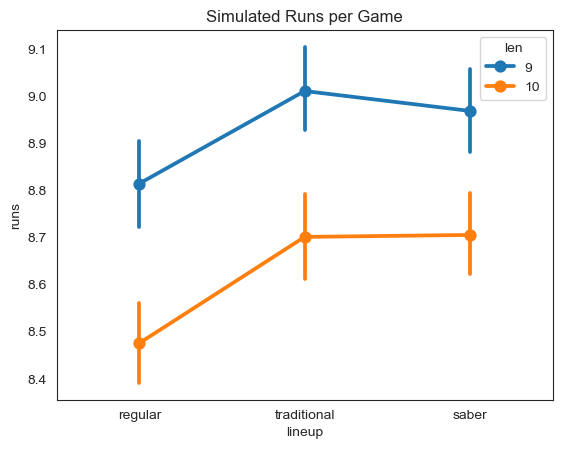

In [85]:
ax = sns.pointplot(manual_pass_df, x='lineup', y='runs', hue='len')
ax.set_title('Simulated Runs per Game')

In [86]:
# Hell yeah we're going to brute force every permutation with these 9 players.
starting_perms = [n for n in permutations(bayes_df.loc[bayes_df.index.isin(lineup_pool)].index[:9])]
len(starting_perms)

362880

In [87]:
results = Parallel(n_jobs=12, verbose=1)(delayed(get_results)(n, n_iter=1000) for n in starting_perms)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    6.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 4976 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 8426 tasks      | elapsed: 24.7min
[Parallel(n_jobs=12)]: Done 9776 tasks      | elapsed: 28.7min
[Parallel(n_jobs=12)]: Done 11226 tasks      

In [88]:
def parse_results(results):
    df = pd.DataFrame(results).T
    rm_df = df.mean().rename('runs_mean').to_frame()
    rm_df['std_mean'] = df.std() / np.sqrt(1000)
    rm_df['ci_low'] = rm_df['runs_mean'] - 1.96 * rm_df['std_mean']
    rm_df['ci_high'] = rm_df['runs_mean'] + 1.96 * rm_df['std_mean']
    return rm_df

In [89]:
rm_df = parse_results(results)

In [90]:
best_rands = rm_df.loc[rm_df['runs_mean'] > rm_df['ci_low'].max()].index
len(best_rands)

2120

In [91]:
final_lineup_opt_results = Parallel(n_jobs=12, verbose=1)(delayed(get_results)(starting_perms[i], n_iter=10000) for i in best_rands)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 24.7min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed: 39.3min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed: 57.6min
[Parallel(n_jobs=12)]: Done 2120 out of 2120 | elapsed: 67.9min finished


In [92]:
final_df = parse_results(final_lineup_opt_results)
final_df = final_df.loc[final_df.runs_mean > final_df.ci_low.max()].copy()
len(final_df)

1897

In [93]:
final_df.sort_values('runs_mean', ascending=False, inplace=True)
final_df.head()

,runs_mean,std_mean,ci_low,ci_high
948,9.1918,0.144791,8.908009,9.475591
928,9.1689,0.145431,8.883856,9.453944
84,9.1646,0.145030,8.880340,9.448860
22,9.1561,0.144646,8.872594,9.439606
52,9.1539,0.145682,8.868363,9.439437


<Axes: xlabel='runs_mean', ylabel='Count'>

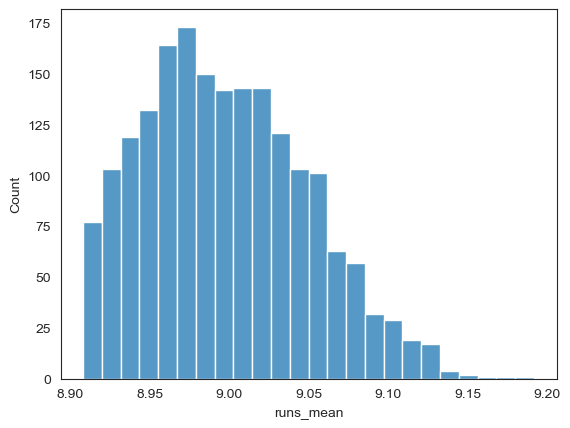

In [94]:
sns.histplot(final_df.runs_mean)

In [95]:
pos_df = pd.DataFrame([starting_perms[best_rands[n]] + (final_df.loc[n, 'runs_mean'], ) for n in final_df.loc[final_df.runs_mean > 9.10].index], columns=[n for n in range(1, 10)] + ['runs'])
pos_df.head()

,1,2,3,4,5,6,7,8,9,runs
0,Rico Pena,Cody Stevens,Kasim Hussain,Kellen Hatheway,Derek Chance,Alexander Delk,Brian Holman,Adam Tuszynski,Ryan Stevens,9.1918
1,Rico Pena,Cody Stevens,Kellen Hatheway,Kasim Hussain,Brian Holman,Derek Chance,Adam Tuszynski,Alexander Delk,Ryan Stevens,9.1689
2,Cody Stevens,Kasim Hussain,Kellen Hatheway,Derek Chance,Brian Holman,Alexander Delk,Adam Tuszynski,Rico Pena,Ryan Stevens,9.1646
3,Cody Stevens,Kellen Hatheway,Rico Pena,Alexander Delk,Kasim Hussain,Brian Holman,Adam Tuszynski,Derek Chance,Ryan Stevens,9.1561
4,Cody Stevens,Kellen Hatheway,Derek Chance,Alexander Delk,Kasim Hussain,Adam Tuszynski,Brian Holman,Ryan Stevens,Rico Pena,9.1539


In [96]:
pos_df.groupby(1).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
1,,
Cody Stevens,228.0101,9.120404
Rico Pena,164.2665,9.125917
Brian Holman,72.9098,9.113725
Adam Tuszynski,63.8362,9.119457
Kasim Hussain,54.6745,9.112417
Kellen Hatheway,27.3329,9.110967
Ryan Stevens,18.2115,9.105750
Alexander Delk,9.1014,9.101400


In [97]:
pos_df.groupby(2).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
2,,
Cody Stevens,191.5712,9.122438
Rico Pena,109.3441,9.112008
Kasim Hussain,91.2018,9.120180
Brian Holman,91.1956,9.119560
Kellen Hatheway,73.0090,9.126125
Alexander Delk,27.3768,9.125600
Adam Tuszynski,27.3067,9.102233
Ryan Stevens,18.2155,9.107750
Derek Chance,9.1222,9.122200


In [98]:
pos_df.groupby(3).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
3,,
Kasim Hussain,173.2636,9.119137
Kellen Hatheway,109.4849,9.123742
Cody Stevens,100.2728,9.115709
Rico Pena,91.2391,9.123910
Brian Holman,45.5579,9.111580
Alexander Delk,45.5407,9.108140
Adam Tuszynski,36.4896,9.122400
Derek Chance,18.2632,9.131600
Ryan Stevens,18.2311,9.115550


In [99]:
pos_df.groupby(4).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
4,,
Kasim Hussain,145.9412,9.121325
Kellen Hatheway,127.7328,9.123771
Adam Tuszynski,72.9096,9.113700
Derek Chance,63.8396,9.119943
Cody Stevens,63.7717,9.110243
Rico Pena,54.6675,9.111250
Alexander Delk,36.5375,9.134375
Ryan Stevens,36.4857,9.121425
Brian Holman,36.4573,9.114325


In [100]:
pos_df.groupby(5).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
5,,
Derek Chance,127.6292,9.116371
Kellen Hatheway,109.3818,9.115150
Adam Tuszynski,109.3720,9.114333
Brian Holman,100.3782,9.125291
Alexander Delk,54.7378,9.122967
Kasim Hussain,45.6706,9.134120
Cody Stevens,36.5002,9.125050
Rico Pena,36.4467,9.111675
Ryan Stevens,18.2264,9.113200


In [101]:
pos_df.groupby(6).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
6,,
Derek Chance,173.2969,9.120889
Adam Tuszynski,118.5019,9.115531
Kellen Hatheway,109.3840,9.115333
Alexander Delk,63.9566,9.136657
Brian Holman,54.7376,9.122933
Ryan Stevens,36.4491,9.112275
Kasim Hussain,36.4377,9.109425
Rico Pena,27.3622,9.120733
Cody Stevens,18.2169,9.108450


In [102]:
pos_df.groupby(7).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
7,,
Alexander Delk,163.9951,9.110839
Adam Tuszynski,109.5209,9.126742
Brian Holman,109.4906,9.124217
Derek Chance,91.2157,9.121570
Ryan Stevens,63.8197,9.117100
Kellen Hatheway,36.4722,9.118050
Kasim Hussain,36.4661,9.116525
Rico Pena,27.3626,9.120867


In [103]:
pos_df.groupby(8).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
8,,
Ryan Stevens,182.3068,9.115340
Alexander Delk,164.1698,9.120544
Derek Chance,91.2143,9.121430
Brian Holman,63.8319,9.118843
Adam Tuszynski,54.7810,9.130167
Kellen Hatheway,45.5453,9.109060
Rico Pena,18.2816,9.140800
Kasim Hussain,18.2122,9.106100


In [104]:
pos_df.groupby(9).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
9,,
Ryan Stevens,246.3971,9.125819
Rico Pena,109.3726,9.114383
Alexander Delk,72.9272,9.115900
Brian Holman,63.7840,9.112000
Derek Chance,63.7618,9.108829
Adam Tuszynski,45.6250,9.125000
Kasim Hussain,36.4752,9.118800


In [106]:
lineup = ['blank' for n in range(9)]
effect_sizes = [pos_df.groupby(n).runs.sum().max() for n in range(1, 10)]
for n in np.argsort(effect_sizes)[::-1]:
    counts = pos_df.groupby(n+1).runs.sum().sort_values(ascending=False)
    lineup[n] = counts.loc[~counts.index.isin(lineup)].index[0]
lineup

['Cody Stevens',
 'Rico Pena',
 'Kasim Hussain',
 'Kellen Hatheway',
 'Brian Holman',
 'Derek Chance',
 'Adam Tuszynski',
 'Alexander Delk',
 'Ryan Stevens']

In [107]:
opt_results = get_results(tuple(lineup), n_iter=10000)

In [108]:
opt10_results = get_results(tuple(lineup + ['Steven Ferguson']), n_iter=10000)

In [109]:
manual_pass_df = pd.DataFrame([reg9_results, trad_results, sabr_results, reg_results, trad10_results, sabr10_results, opt_results, opt10_results],
                              index=['regular 9', 'traditional 9', 'saber 9', 'regular 10', 'traditional 10', 'saber 10', 'optimized 9', 'optimized 10']).T
manual_pass_df = manual_pass_df.stack().reset_index(level=0, drop=True).reset_index()
manual_pass_df['lineup'] = manual_pass_df['index'].str.split(' ').str[0]
manual_pass_df['len'] = manual_pass_df['index'].str.split(' ').str[-1]
manual_pass_df.rename(columns={0: 'runs'}, inplace=True)

Text(0.5, 1.0, 'Simulated Runs per Game')

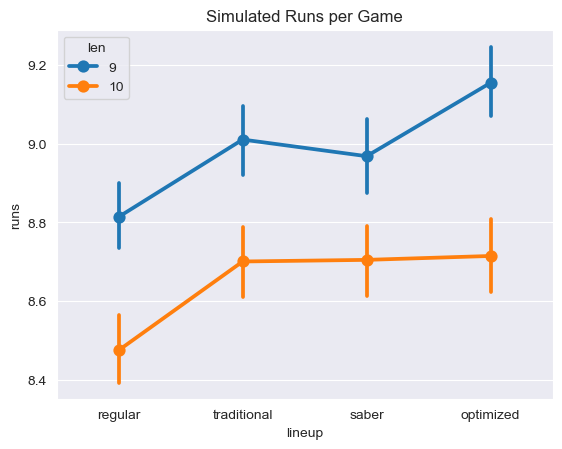

In [110]:
ax = sns.pointplot(manual_pass_df, x='lineup', y='runs', hue='len')
ax.set_title('Simulated Runs per Game')